In [11]:
import os
import openslide

import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image, ImageDraw, ImageFont
from typing import Dict, Tuple, List

import math
from collections import Counter
from openslide import OpenSlide
from openslide.deepzoom import DeepZoomGenerator

from draw_utils import *


In [2]:
# slide_path = '/home/nas2_fast/Data/Pathology_project/KBSMC/wsi/1-028_08.svs'
slide_path = '/home/sjhong/DB-000037-B2.svs'
wsi_name = slide_path.split('/')[-1][:-4]
slide = openslide.OpenSlide(slide_path)
print(wsi_name, slide.dimensions, slide.properties[openslide.PROPERTY_NAME_MPP_X])

DB-000037-B2 (187325, 80564) 0.26392599999999999


In [3]:
output_dir = f'/home/sjhong/segmentation/histoplus/tile_figure/{wsi_name}'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print('Make directory for',output_dir)

In [4]:
json_path = f'/home/sjhong/segmentation/histoplus/output/PNU/seg_{wsi_name}.json'
with open(json_path, 'r') as f:
    results = json.load(f)

In [5]:
TARGET_CELLTYPE = list(COLOR_MAP.keys())
TARGET_CELLTYPE.remove('Red blood cell')
TARGET_CELLTYPE

['Apoptotic Body',
 'Cancer cell',
 'Endothelial Cell',
 'Eosinophils',
 'Epithelial',
 'Fibroblasts',
 'Lymphocytes',
 'Macrophages',
 'Minor Stromal Cell',
 'Mitotic Figures',
 'Muscle Cell',
 'Neutrophils',
 'Plasmocytes']

In [6]:
tiles_list = []

for t in results.get("cell_masks", []):
    matched_types = set()   # 이 타일에서 발견된 타입(중복 제거)
    hit_count = 0           # 매칭된 마스크 총 개수(원하면 유지)

    for m in t.get("masks", []):
        ct = m.get("cell_type")
        # 대상 타입 중 하나라도 부분 일치하면 기록
        matched = False
        for target in TARGET_CELLTYPE:
            if target in ct:
                matched_types.add(target)
                matched = True
        if matched:
            hit_count += 1

    if matched_types:
        tiles_list.append({
            "x": t["x"], "y": t["y"], "level": t["level"],
            "width": t["width"], "height": t["height"],
            "count": hit_count,                     # 매칭된 마스크 수
            "types": sorted(matched_types)         # ✅ 중복 없이 1회씩만
        })
tiles_sorted = sorted(   tiles_list,    key=lambda x: x["count"],    reverse=True)
print(f"총 타일 수: {len(tiles_sorted)}")
for r in tiles_sorted[:10]:
    print(r)

총 타일 수: 14583
{'x': 123.0, 'y': 92.0, 'level': 17.0, 'width': 224.0, 'height': 224.0, 'count': 143, 'types': ['Apoptotic Body', 'Cancer cell', 'Lymphocytes', 'Minor Stromal Cell']}
{'x': 135.0, 'y': 91.0, 'level': 17.0, 'width': 224.0, 'height': 224.0, 'count': 140, 'types': ['Apoptotic Body', 'Cancer cell', 'Fibroblasts', 'Lymphocytes', 'Minor Stromal Cell', 'Muscle Cell']}
{'x': 84.0, 'y': 102.0, 'level': 17.0, 'width': 224.0, 'height': 224.0, 'count': 140, 'types': ['Endothelial Cell', 'Fibroblasts', 'Lymphocytes', 'Macrophages']}
{'x': 114.0, 'y': 90.0, 'level': 17.0, 'width': 224.0, 'height': 224.0, 'count': 139, 'types': ['Cancer cell', 'Fibroblasts', 'Lymphocytes', 'Minor Stromal Cell']}
{'x': 86.0, 'y': 154.0, 'level': 17.0, 'width': 224.0, 'height': 224.0, 'count': 139, 'types': ['Apoptotic Body', 'Cancer cell', 'Fibroblasts', 'Lymphocytes', 'Macrophages', 'Muscle Cell']}
{'x': 85.0, 'y': 154.0, 'level': 17.0, 'width': 224.0, 'height': 224.0, 'count': 138, 'types': ['Cancer ce

In [7]:
import numpy as np
tiles_sorted_masks = [True if t['count']>100 else False for t in tiles_sorted]
tiles_filtered = list(np.array(tiles_sorted)[tiles_sorted_masks])
len(tiles_filtered)

366

In [8]:
dz = DeepZoomGenerator(slide, tile_size=224, overlap=0, limit_bounds=True)

In [17]:

def draw_masks(dz, tile_masks, region_base, TILE_INFO:Dict, COLOR_MAP = COLOR_MAP, DEFAULT_COLOR = DEFAULT_COLOR):
    '''
    W_dz, H_dz = dz.level_dimensions[lvl]
    sx, sy = W0/float(W_dz), H0/float(H_dz)   # dz 픽셀 → base 픽셀 스케일

    # 타일 좌상단 base 좌표 (overlap=0 → step=tile_size)
    step = int(tile["width"])                  # 보통 224
    x0 = int(round(tx * step * sx))
    y0 = int(round(ty * step * sy))

    # 실제 DZ 타일 크기(가장자리 보정)
    img_dz = dz.get_tile(lvl, (tx, ty))        # PIL, dz level의 실제 타일 크기
    w0 = int(round(img_dz.width  * sx))
    h0 = int(round(img_dz.height * sy))
    '''

    # Histoplus가 쓰는 tile_size=224, overlap=0 가정
    
    lvl = int(TILE_INFO['lvl'])
    tx, ty = int(TILE_INFO['txy'][0]), int(TILE_INFO['txy'][1])

    img_dz = dz.get_tile(lvl, (tx, ty))        # PIL, dz level의 실제 타일 크기

    # --- 폴리곤 그릴 때 사용할 스케일: (타일 로컬 → base region 크기) ---
    scale_x = int(TILE_INFO['wh0'][0]) / float(img_dz.width)         # 예: 448/224 = 2.0
    scale_y = int(TILE_INFO['wh0'][0]) / float(img_dz.height)

    region = region_base.copy()
    draw = ImageDraw.Draw(region, "RGBA")
    # 이 tile에 속한 mask들만 추출

    # --- 폴리곤/센트로이드 오버레이 ---
    for m in tile_masks:
        ctype = m.get("cell_type")
        color = COLOR_MAP.get(ctype, DEFAULT_COLOR)

        # 타일 로컬(≈224×224) 좌표 → base region 좌표로 스케일링
        pts = [(x*scale_x, y*scale_y) for (x, y) in m["coordinates"]]
        draw.line(pts + [pts[0]], fill=color, width=2)

        if "centroid" in m:
            cx, cy = m["centroid"]
            cx, cy = cx*scale_x, cy*scale_y
            r = 3
            draw.ellipse([cx-r, cy-r, cx+r, cy+r], outline="white", fill=color)
            
    return region

def make_cnt_panel(tile_masks, color_map, width=200, pad=12, lh=18):
    """
    오른쪽 annotation 패널(클래스 목록 + 개수 + 메타정보)
    """
    font = load_font(14)
    # 클래스 카운트 (빈도 요약만 패널에 표시; 원한다면 제거해도 됨)
    cnt = Counter((m.get("cell_type") or "unknown").strip() for m in tile_masks)
    rows = sorted(cnt.items(), key=lambda kv: (-kv[1], kv[0]))

    # 패널 높이 계산(헤더/메타 + 클래스 행 수)
    height = pad*2 + lh* (4 + len(rows))
    panel = Image.new("RGB", (width, height), (255,255,255))
    d = ImageDraw.Draw(panel)

    y = pad
    y += 4
    for label, c in rows:
        color = hex_to_rgb(color_map.get(label, DEFAULT_COLOR))
        # 색상 박스
        d.rectangle([pad, y+4, pad+12, y+16], fill=color, outline=None)
        d.text((pad+18, y), f"{label} ({c})", font=font, fill=(0,0,0))
        y += lh

    return panel

def draw_annotation(dz, tile_mask,region_base, cfg, tile_masks, COLOR_MAP, DEFAULT_COLOR):
    panel = make_cnt_panel(tile_masks, COLOR_MAP, width=200)

    # 좌측(region) + 우측(panel) 나란히 합치기
    region = draw_masks(dz, tile_mask, region_base, cfg, COLOR_MAP = COLOR_MAP, DEFAULT_COLOR = DEFAULT_COLOR)
    H = max(region.height, panel.height)
    canvas = Image.new("RGB", (region.width + panel.width, H), (255,255,255))
    canvas.paste(region, (0, 0))
    canvas.paste(panel, (region.width, 0))

    return canvas

def draw_together(region_base, canvas, show_fig = False):
    compare = Image.new("RGB", (region_base.width + canvas.width + 10, region_base.height), (255,255,255))
    compare.paste(region_base, (0, 0))
    compare.paste(canvas, (region_base.width+ 10, 0))
    if show_fig:
        plt.imshow(compare)
    else:
        return compare
    
def save_png_current_res(img, path):
    # PNG 저장 시 dpi 메타가 int로 있으면 제거(또는 튜플화)
    if "dpi" in img.info:
        dpi_val = img.info["dpi"]
        if isinstance(dpi_val, int):
            # 1) 그냥 없애고 저장 (메타 제거)
            img.info.pop("dpi", None)
            # 2) 또는 튜플로 정상화해서 저장 원하면 아래 사용:
            # img.save(path, dpi=(dpi_val, dpi_val)); return
    img.save(path)

In [18]:
for tile in tiles_filtered[:10]:
    tile_masks = []
    for t in results.get("cell_masks", []):
        if (
            int(t["x"]) == int(tile["x"]) and
            int(t["y"]) == int(tile["y"]) and
            int(t["level"]) == int(tile["level"]) and
            int(t["width"]) == int(tile["width"]) and
            int(t["height"]) == int(tile["height"])
        ):
            tile_masks = t.get("masks", [])
            break

    print(f"tile_masks 개수: {len(tile_masks)}")

    file_name_patch = '-'.join([wsi_name,'tile',str(int(tile['x'])),str(int(tile['y'])),'patched'])+'.png'
    file_name_annot = '-'.join([wsi_name,'tile',str(int(tile['x'])),str(int(tile['y'])),'annotated'])+'.png'
    file_name_comp = '-'.join([wsi_name,'tile',str(int(tile['x'])),str(int(tile['y'])),'compared'])+'.png'
    output_path_p = os.path.join(output_dir, file_name_patch)
    output_path_a = os.path.join(output_dir, file_name_annot)
    output_path_c = os.path.join(output_dir, file_name_comp)


    region_base, cfg = get_base_patch(tile, slide)
    canvas = draw_annotation(dz, tile_masks, region_base, cfg, tile_masks, COLOR_MAP, DEFAULT_COLOR)
    drawed = draw_together(region_base, canvas)

    save_png_current_res(region_base, output_path_p)
    save_png_current_res(canvas, output_path_a)
    save_png_current_res(drawed, output_path_c)

tile_masks 개수: 144
해당 타일에서 관찰된 cell types → Apoptotic Body, Cancer cell, Lymphocytes, Minor Stromal Cell
tile_masks 개수: 141
해당 타일에서 관찰된 cell types → Apoptotic Body, Cancer cell, Fibroblasts, Lymphocytes, Minor Stromal Cell, Muscle Cell
tile_masks 개수: 149
해당 타일에서 관찰된 cell types → Endothelial Cell, Fibroblasts, Lymphocytes, Macrophages
tile_masks 개수: 139
해당 타일에서 관찰된 cell types → Cancer cell, Fibroblasts, Lymphocytes, Minor Stromal Cell
tile_masks 개수: 140
해당 타일에서 관찰된 cell types → Apoptotic Body, Cancer cell, Fibroblasts, Lymphocytes, Macrophages, Muscle Cell
tile_masks 개수: 138
해당 타일에서 관찰된 cell types → Cancer cell, Fibroblasts, Lymphocytes, Macrophages, Minor Stromal Cell, Plasmocytes
tile_masks 개수: 139
해당 타일에서 관찰된 cell types → Apoptotic Body, Cancer cell, Endothelial Cell, Fibroblasts, Lymphocytes, Minor Stromal Cell, Muscle Cell
tile_masks 개수: 138
해당 타일에서 관찰된 cell types → Cancer cell, Fibroblasts, Lymphocytes, Minor Stromal Cell, Muscle Cell
tile_masks 개수: 136
해당 타일에서 관찰된 cell types → Ca

In [25]:
def dz_pixel_to_base(slide, dz, dz_level, x_dz, y_dz):
    W0, H0 = slide.dimensions
    W_dz, H_dz = dz.level_dimensions[dz_level]
    sx = W0 / float(W_dz)
    sy = H0 / float(H_dz)
    bx, by, _, _ = get_bounds_offset(slide)
    x0 = int(round(x_dz * sx)) + bx
    y0 = int(round(y_dz * sy)) + by
    return x0, y0

def dz_tile_to_base(slide, dz, dz_level, tx, ty, tile_size=224, overlap=0):
    step = tile_size - overlap
    x_dz = tx * step
    y_dz = ty * step
    return dz_pixel_to_base(slide, dz, dz_level, x_dz, y_dz)

In [21]:

from histoplus.helpers.tissue_detection import detect_tissue_on_wsi

In [22]:

tissue_coords, dz_level = detect_tissue_on_wsi(slide)

2025-09-18 14:42:08.784 | INFO     | histoplus.helpers.tiling.optimal_mpp:get_tiling_slide_level:149 - 8.445632 is the closest available MPP to the one requested (8.0). Minimal MPP of the slide is 0.263926.
2025-09-18 14:42:08.786 | INFO     | histoplus.helpers.tiling.optimal_mpp:get_tiling_slide_level:149 - 0.527852 is the closest available MPP to the one requested (0.5). Minimal MPP of the slide is 0.263926.
2025-09-18 14:42:17.711 | INFO     | histoplus.helpers.tissue_detection.core:detect_tissue_on_wsi:80 - Found 15897 tiles with Otsu's threshold.


In [26]:
tx, ty = 85, 154
dz_tile_to_base(slide, dz, dz_level, tx, ty, tile_size=224, overlap=0)

(38080, 68992)

In [27]:

def find_nearest_tiles(base_xy, tile_coords, patch_size=224, topk=2):
    """
    원본 좌표(base_xy)에 가장 가까운 타일을 topk개 제안
    - base_xy: (x,y), 원본 좌표
    - tile_coords: shape (N,2), 각 타일의 좌상단 좌표
    - patch_size: 타일 크기
    - topk: 몇 개 후보 타일을 반환할지
    """
    centers = tile_coords + patch_size/2.0  # 타일 중심 좌표
    tree = cKDTree(centers)
    dists, idxs = tree.query(np.array(base_xy), k=topk)

    if topk == 1:
        idxs = [idxs]
        dists = [dists]

    results = []
    for i, (idx, dist) in enumerate(zip(idxs, dists)):
        cx, cy = centers[idx]
        results.append({
            "rank": i,
            "tile_index": int(idx),
            "tile_top_left": tile_coords[idx].tolist(),
            "tile_center": (float(cx), float(cy)),
            "distance": float(dist)
        })
    return results


In [30]:

from scipy.spatial import cKDTree


In [31]:
nearest = find_nearest_tiles((71684, 54809), tissue_coords, patch_size=224, topk=2)
for r in nearest:
    print(r)

{'rank': 0, 'tile_index': 15634, 'tile_top_left': [373, 155], 'tile_center': (485.0, 267.0), 'distance': 89689.05933836078}
{'rank': 1, 'tile_index': 8615, 'tile_top_left': [396, 124], 'tile_center': (508.0, 236.0), 'distance': 89689.66108197755}


In [23]:
dz_level

17

In [24]:
x_dz, y_dz = 85, 154
dz_pixel_to_base(slide, dz, dz_level, x_dz, y_dz)

(170, 308)

In [ ]:
tissue_coords, dz_level = detect_tissue_on_wsi(slide)

In [32]:
import xml.etree.ElementTree as ET

xml_path = "/home/sjhong/simple_filtered_bbox_annotations_heatmap_reflect_DB-000037-B2.xml"
tree = ET.parse(xml_path)
root = tree.getroot()

annots = root.find("Annotations")
unique_colors = {
    (a.get("Color") or "").upper()          # 대문자로 정규화
    for a in annots.findall("Annotation")
    if a.get("Color")
}
print("Unique colors:", sorted(unique_colors))

Unique colors: ['#000089', '#00008D', '#000092', '#000096', '#00009B', '#00009F', '#0000A4', '#0000A8', '#0000AD', '#0000B2', '#0000B6', '#0000BB', '#0000BF', '#0000C4', '#0000C8', '#0000CD', '#0000D1', '#0000D6', '#0000DA', '#0000DF', '#0000E3', '#0000E8', '#0000ED', '#0000F1', '#0000F6', '#0000FA', '#0000FF', '#0004FF', '#0008FF', '#000CFF', '#0010FF', '#0014FF', '#0018FF', '#001CFF', '#0020FF', '#0024FF', '#0028FF', '#002CFF', '#0030FF', '#0034FF', '#0038FF', '#003CFF', '#0040FF', '#0044FF', '#0048FF', '#004CFF', '#0050FF', '#0054FF', '#0058FF', '#005CFF', '#0060FF', '#0064FF', '#0068FF', '#006CFF', '#0070FF', '#0074FF', '#0078FF', '#007CFF', '#0080FF', '#0084FF', '#0088FF', '#008CFF', '#0090FF', '#0094FF', '#0098FF', '#009CFF', '#00A0FF', '#00A4FF', '#00A8FF', '#00ACFF', '#00B0FF', '#00B4FF', '#00B8FF', '#00BCFF', '#00C0FF', '#00C4FF', '#00C8FF', '#00CCFF', '#00D0FF', '#00D4FF', '#00D8FF', '#00DCFE', '#00E0FB', '#00E4F8', '#02E8F4', '#06ECF1', '#09F0EE', '#0CF4EB', '#0FF8E7', '#13F

In [34]:
len(unique_colors)

187

In [35]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Blue-ish: ['#005CFF', '#00E4F8', '#006CFF', '#50FFA7', '#0000B6']
Red-ish: ['#FFDB00', '#C1FF36', '#A0FF56', '#9DFF5A', '#920000']


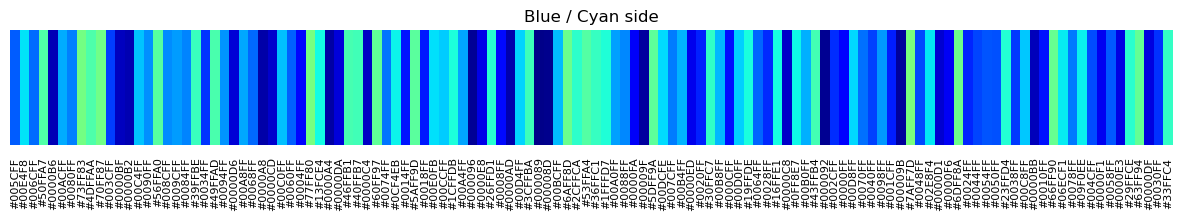

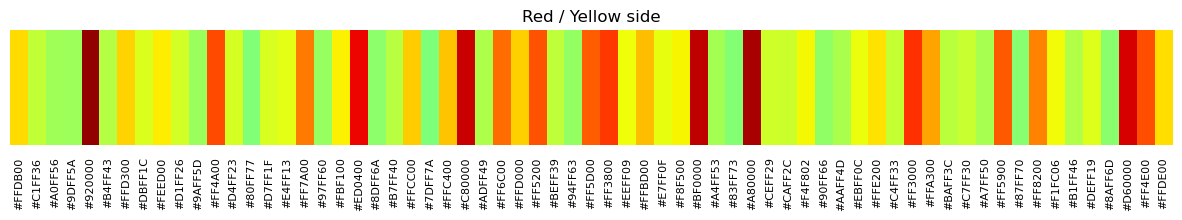

In [37]:
# ---- 파랑/빨강 계열 분리 (단순하게 R > G 기준으로 나눔) ----
def is_red_family(hex_color):
    h = hex_color.lstrip("#")
    r, g, b = [int(h[i:i+2], 16) for i in (0, 2, 4)]
    return r >= b  # 빨강쪽이면 True

blue_family = [c for c in unique_colors if not is_red_family(c)]
red_family  = [c for c in unique_colors if is_red_family(c)]

print("Blue-ish:", blue_family[:5])
print("Red-ish:", red_family[:5])

# ---- 시각화 패널 ----
def show_color_panel(colors, title="Colors"):
    n = len(colors)
    fig, ax = plt.subplots(figsize=(min(15, n*0.4), 1.5))
    ax.set_xlim(0, n)
    ax.set_ylim(0, 1)
    ax.axis("off")

    for i, col in enumerate(colors):
        rect = patches.Rectangle((i, 0), 1, 1, facecolor=col)
        ax.add_patch(rect)
        ax.text(i+0.5, -0.1, col, ha="center", va="top", fontsize=8, rotation=90)

    plt.title(title)
    plt.show()

# ---- 패널 두 개 그리기 ----
show_color_panel(blue_family, title="Blue / Cyan side")
show_color_panel(red_family,  title="Red / Yellow side")

/tmp/ipykernel_1646328/2690724001.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet', n)


mid(0.5) color ≈ #7BFF7B


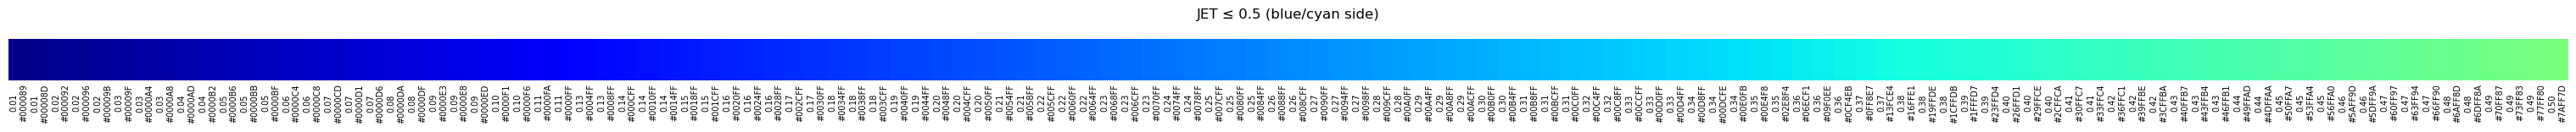

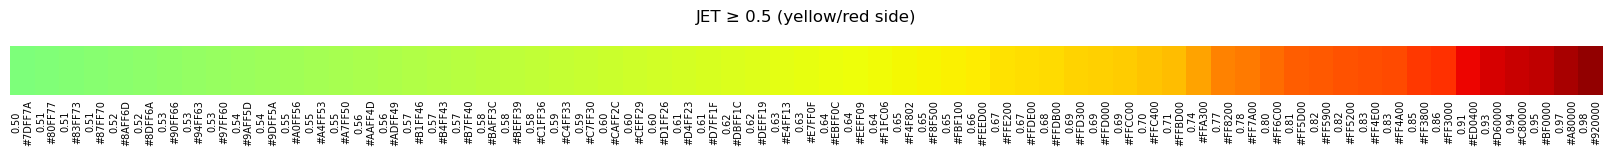

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm

# --- 입력: ASAP에서 뽑은 Unique colors (HEX 문자열 리스트) ---
# unique_colors = [...]  # 이미 있으니 그대로 사용

def hex_to_rgb(hex_str):
    h = hex_str.lstrip('#')
    return np.array([int(h[0:2],16), int(h[2:4],16), int(h[4:6],16)], dtype=float)

def build_jet_lut(n=2048):
    cmap = cm.get_cmap('jet', n)
    # 0..1을 n등분 샘플→ 0..255 RGB로
    rgb = (cmap(np.linspace(0,1,n))[:,:3] * 255.0).astype(float)
    return rgb  # shape: (n,3)

def nearest_jet_position(hex_color, jet_rgb):
    """HEX를 jet LUT에서 가장 가까운 색으로 매칭, 반환: (s, idx)"""
    rgb = hex_to_rgb(hex_color)
    # 제곱거리 가장 작은 인덱스
    d2 = np.sum((jet_rgb - rgb)**2, axis=1)
    idx = int(np.argmin(d2))
    s = idx / (len(jet_rgb)-1)
    return s, idx

def split_colors_by_jet_mid(unique_colors, mid=0.5, lut_size=2048):
    jet_rgb = build_jet_lut(lut_size)
    items = []
    for c in unique_colors:
        s, i = nearest_jet_position(c, jet_rgb)
        items.append((c, s, i))
    # s 기준으로 정렬해두면 보기 좋음
    items.sort(key=lambda x: x[1])
    left  = [(c,s) for (c,s,_) in items if s < mid]
    right = [(c,s) for (c,s,_) in items if s >= mid]
    # s=0.5의 정확한 jet 색
    mid_hex = '#%02X%02X%02X' % tuple(build_jet_lut(1001)[int(mid*1000)].astype(int))
    return left, right, mid_hex

def show_color_panel(items, title="panel"):
    """items: [(hex, s), ...]  s 오름차순 가정"""
    n = len(items)
    fig, ax = plt.subplots(figsize=(max(4, n*0.25), 1.6))
    ax.set_xlim(0, n); ax.set_ylim(0, 1); ax.axis("off")
    for i, (hex_c, s) in enumerate(items):
        ax.add_patch(patches.Rectangle((i, 0.2), 1, 0.6, facecolor=hex_c, edgecolor='none'))
        ax.text(i+0.5, 0.15, f"{s:.2f}\n{hex_c}", ha="center", va="top", fontsize=7, rotation=90)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# ---- 실행 ----
left, right, mid_hex = split_colors_by_jet_mid(unique_colors, mid=0.5, lut_size=4096)
print(f"mid(0.5) color ≈ {mid_hex}")

# 왼쪽(blue/cyan 쪽), 오른쪽(yellow/red 쪽) 패널 각각 표시
show_color_panel(left,  title="JET ≤ 0.5 (blue/cyan side)")
show_color_panel(right, title="JET ≥ 0.5 (yellow/red side)")


In [ ]:
'#7DFF7A' in red_family

True

: 